In [1]:
import numpy as np
import time
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
#fetch the mnist dataset
x, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
print(x.shape,y.shape)

(70000, 784) (70000,)


In [3]:
#x_n = x.to_numpy()
x_n = x
#y_n = y.to_numpy()
y_n = y

In [4]:
y_n = y_n.astype('int') #convert output to integers 0-9
x_norm = x_n/255.0 #normalise input data
x_train, x_val, y_train, y_val = train_test_split(x_norm, y_n, test_size=0.1, random_state=42) #split the data into train and validation
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

x_train = x_train.T #take the transpose of the training data m*784 -> 784*m
x_val = x_val.T #take the transpose of the test data m*784 -> 784*m
print(x_train.shape, x_val.shape)

(63000, 784) (7000, 784) (63000,) (7000,)
(784, 63000) (784, 7000)


In [5]:
def saveText(fPath, arr):
    #dim1, dim2 = arr.shape
    f = open(fPath, 'a')
    np.savetxt(f, arr.flatten(), newline = ', ')
    f.write("\n")
    f.close()

In [6]:
#have to change with different number of layers
def params_init():

  #np.random.seed(2)
  W1 = np.random.rand(500,784) - 0.5
  b1 = np.random.rand(500,1) - 0.5
  W2 = np.random.rand(500,500) - 0.5
  b2 = np.random.rand(500,1) - 0.5
  W3 = np.random.rand(10,500) - 0.5 
  b3 = np.random.rand(10,1) - 0.5
  #W4 = np.random.rand(50,200) - 0.5   
  #b4 = np.random.rand(50,1) - 0.5    
  #W5 = np.random.rand(10,50) - 0.5  
  #b5 = np.random.rand(10,1) - 0.5    
  print("Params Initialised")

  return (W1, b1, W2, b2, W3, b3)


#have to change with different number of layers
def forward(x_train, W1, b1, W2, b2, W3, b3):
  #print("Entered FP")
  Z1 = np.matmul(W1,x_train) + b1 #W1 is 50*784, x_train is 748*m, Z1 is 50*m
  A1 = relu(Z1)

  Z2 = np.matmul(W2,A1) + b2 
  A2 = relu(Z2)

  Z3 = np.matmul(W3,A2) + b3
  A3 = softmax(Z3)
  
  #Z4 = np.matmul(W4,A3) + b4
  #A4 = relu(Z4)

  #Z5 = np.matmul(W5,A4) + b5
  #A5 = softmax(Z5)

  #W2 is 10*50, A1 is 50*m
  # print(np.exp(Z2))
  # print(np.sum(np.exp(Z2)))

  #A2 is 10*m, final predictions
  # print("Fp Done")

  return Z1, A1, Z2, A2, Z3, A3


def relu(x):
   return np.maximum(x,0)


def softmax(Z):
  return np.exp(Z) / np.sum(np.exp(Z),0)


def relu_d(x):
  return x>0


def one_hot_encoding(y):
  shape = (y.shape[0], 10)
  one_hot = np.zeros(shape)
  rows = np.arange(y.size)
  one_hot[rows, y] = 1
  return one_hot.T


#have to change with different number of layers
def backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, y):
  # print("Entered Backprop")
  m = y.shape[0] #m is the number of training examples
  Y = one_hot_encoding(y)

  dZ3 = (A3 - Y)
  
  dW3 = 1/m*np.matmul(dZ3,A2.T)

  db3 = 1/m*np.sum(dZ3, axis=1)

  dZ2 = np.matmul(W3.T, dZ3)*relu_d(Z2) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW2 = 1/m*np.matmul(dZ2,A1.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db2 = 1/m*np.sum(dZ2, axis=1) #db1 is 50*1

  dZ1 = np.matmul(W2.T, dZ2)*relu_d(Z1) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW1 = 1/m*np.matmul(dZ1,X.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis = 1) #db1 is 50*1


  return dW1, db1, dW2, db2, dW3, db3


#have to change with different number of layers
def param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr, factor=0):

  #updates the parameters based on backpropogation

  W1 = W1 - lr*dW1
  b1 = b1 - lr*(db1.reshape(b1.shape))
  W2 = W2 - lr*dW2
  b2 = b2 - lr*(db2.reshape(b2.shape))
  W3 = W3 - lr*dW3
  b3 = b3 - lr*(db3.reshape(b3.shape))
  #W4 = W4 - lr*dW4
  #b4 = b4 - lr*db4

  return W1, b1, W2, b2, W3, b3


#have to change with different number of layers
def batch_grad_descent(X,Y,iter, lr, print_op=1, decay_factor=0):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  mu = 1
  sigma = 0.4

  W1, b1, W2, b2, W3, b3 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)


  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0


    #storing the weights:
    start = time.time()
    basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
    saveText(basePath+"W1.txt", W1)
    saveText(basePath+"W2.txt", W2)
    saveText(basePath+"W3.txt", W3)
    saveText(basePath+"b1.txt", b1)
    saveText(basePath+"b2.txt", b2)
    saveText(basePath+"b3.txt", b3)
    end = time.time()
    print("###Saving weights : {time}".format(time = end - start))


    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1, b1, W2, b2, W3, b3) 

      dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)


      W1, b1, W2, b2, W3, b3 = param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr = lr, factor = decay_factor)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1, b1, W2, b2, W3, b3)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1, b1, W2, b2, W3, b3)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights




def grad_descent(X,Y,iter, lr, print_op, decay_factor=0):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  mu = 1
  sigma = 0.4

  W1, b1, W2, b2, W3, b3 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)


  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0
    X1, Y1 = X.T, Y
    X1 = X1.T #take transpose to match the sizes

    Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1, b1, W2, b2, W3, b3) 

    dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)

    W1, b1, W2, b2, W3, b3 = param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr = lr, factor = decay_factor)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1, b1, W2, b2, W3, b3)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1, b1, W2, b2, W3, b3)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights


def predictions(A):
  #argmax returns the index of maximum value, we will feed the sigmoid output to this function 
  return np.argmax(A,0)


def accuracy(A,Y):
  #this will compare the predicted output to the ground truth
  return np.sum(A == Y)/Y.shape[0]*100


In [63]:
answerToTrain = input("Do you want to train the model again? : ")
if answerToTrain.strip().lower()=='yes':
    W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights = batch_grad_descent(x_train,y_train,100, 0.01,1)

In [8]:
def loadFromLine(line, shape):
    #line = "xx, xxx, x,....., "
    lineElements = np.array([float(x) for x in line.split(", ")[:-1]]).reshape(shape)
    return lineElements

In [9]:
def getVth(mu, sigma, shape):
  #last dimension represents the binary rep for each weight
  return np.random.normal(loc=mu, scale=sigma, size=shape) #each bit is represented by an sram so we need those many vth values for each mosfet in this set

In [47]:
def weightTransformWithVariability(weightArray, precision, step, discreteSteps):
  dim1, dim2 = weightArray.shape
  sizeI = (dim1, dim2, precision)

  clippedWeightIndexArray = np.digitize(np.abs(weightArray), discreteSteps) #finds the index value of the weights

  vDD = 5
  mu = 0.7#mean of the distribution
  sigma = 0.00001
  #! work with sigma/mu
  Vth = getVth(mu, sigma, sizeI)#get the array of Vth values 

  iOn = ((vDD - Vth)**2)*1e-06#scaling the current according to Ioff values arbitraryfor now!!

  
  iOnNominal = 1e-06*(vDD**2 - (2*vDD*mu) + (sigma**2  + mu**2))

  
  iOff = np.random.uniform(low=0, high=1e-10, size = sizeI)#no negative value

  
  analogWeightArray = np.zeros_like(weightArray, dtype=float)

  for bitLevel in range(precision):
    analogWeightArray += np.sign(weightArray) * np.where(np.bitwise_and(clippedWeightIndexArray, 2**bitLevel)>=1, iOn[:, :, bitLevel], iOff[:, :, bitLevel]) * (2**bitLevel)



  weightWithVariability = (analogWeightArray/iOnNominal)*step
  return weightWithVariability

In [11]:
def readWriteTransform(readPath, writePath, shape, precision, step, discreteSteps):
    #basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
    fileOpen = open(readPath, 'r')
    iter = 0
    for line in fileOpen:
        start = time.time()
        saveText(writePath, weightTransformWithVariability(loadFromLine(line, shape), precision, step, discreteSteps))
        end = time.time()
        print("#Finished reading and transforming Line {lineNo} with Time taken = {tTime}".format(lineNo = iter, tTime = end-start))
        iter += 1
    fileOpen.close()
    print("##Fin.##")

# Setting up the variability conditions

In [32]:
precision = 10#setting the precision value of the calculations

In [33]:
wRange = 3

In [34]:
noOfLevels = 2**precision - 1 #no of levels of quantization

In [35]:
step = round(wRange/noOfLevels, precision) #step size of each of the step after quantization

In [36]:
discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps

## Clearing out the variability transformed weights text files for storing the new transformed weights

In [55]:
answer = input("Your response to clear variability transformed weight text files : ")
if answer.lower().strip()=='yes':
    basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
    fileToClear = open(basePath+"W1var.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"W2var.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"W3var.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"b1var.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"b2var.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"b3var.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    print("Variability transformed weights HAVE been cleared!!")
else:
    print("Variability transformed weights have NOT been cleared. You can use those weights!!")

Variability transformed weights have NOT been cleared. You can use those weights!!


## Storing the variability transformed weights in the appropriate text files

In [50]:
basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
readWriteTransform(basePath+"W1.txt", basePath+"W1var.txt", (500, 784), precision, step, discreteSteps)

#Finished reading and transforming Line 0 with Time taken = 1.808149814605713
#Finished reading and transforming Line 1 with Time taken = 1.4721205234527588
#Finished reading and transforming Line 2 with Time taken = 1.4704275131225586
#Finished reading and transforming Line 3 with Time taken = 1.5425994396209717
#Finished reading and transforming Line 4 with Time taken = 1.9975364208221436
#Finished reading and transforming Line 5 with Time taken = 1.6764569282531738
#Finished reading and transforming Line 6 with Time taken = 1.5327346324920654
#Finished reading and transforming Line 7 with Time taken = 1.5519099235534668
#Finished reading and transforming Line 8 with Time taken = 1.5320379734039307
#Finished reading and transforming Line 9 with Time taken = 1.529869556427002
#Finished reading and transforming Line 10 with Time taken = 1.5960822105407715
#Finished reading and transforming Line 11 with Time taken = 1.6048338413238525
#Finished reading and transforming Line 12 with Time

In [56]:
basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
readWriteTransform(basePath+"b1.txt", basePath+"b1var.txt", (500, 1), precision, step, discreteSteps)

#Finished reading and transforming Line 0 with Time taken = 0.0027871131896972656
#Finished reading and transforming Line 1 with Time taken = 0.001779794692993164
#Finished reading and transforming Line 2 with Time taken = 0.002211332321166992
#Finished reading and transforming Line 3 with Time taken = 0.002032756805419922
#Finished reading and transforming Line 4 with Time taken = 0.0020792484283447266
#Finished reading and transforming Line 5 with Time taken = 0.0017781257629394531
#Finished reading and transforming Line 6 with Time taken = 0.0020308494567871094
#Finished reading and transforming Line 7 with Time taken = 0.0019919872283935547
#Finished reading and transforming Line 8 with Time taken = 0.0019419193267822266
#Finished reading and transforming Line 9 with Time taken = 0.0020291805267333984
#Finished reading and transforming Line 10 with Time taken = 0.0019953250885009766
#Finished reading and transforming Line 11 with Time taken = 0.0029578208923339844
#Finished reading

In [57]:
basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
readWriteTransform(basePath+"W2.txt", basePath+"W2var.txt", (500, 500), precision, step, discreteSteps)

#Finished reading and transforming Line 0 with Time taken = 1.0336456298828125
#Finished reading and transforming Line 1 with Time taken = 0.9478423595428467
#Finished reading and transforming Line 2 with Time taken = 0.92055344581604
#Finished reading and transforming Line 3 with Time taken = 0.9214797019958496
#Finished reading and transforming Line 4 with Time taken = 0.9056198596954346
#Finished reading and transforming Line 5 with Time taken = 0.9414968490600586
#Finished reading and transforming Line 6 with Time taken = 1.6580610275268555
#Finished reading and transforming Line 7 with Time taken = 1.558396339416504
#Finished reading and transforming Line 8 with Time taken = 1.5631678104400635
#Finished reading and transforming Line 9 with Time taken = 1.7022051811218262
#Finished reading and transforming Line 10 with Time taken = 1.2239971160888672
#Finished reading and transforming Line 11 with Time taken = 0.9981343746185303
#Finished reading and transforming Line 12 with Time 

In [58]:
basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
readWriteTransform(basePath+"b2.txt", basePath+"b2var.txt", (500, 1), precision, step, discreteSteps)

#Finished reading and transforming Line 0 with Time taken = 0.008914709091186523
#Finished reading and transforming Line 1 with Time taken = 0.0049779415130615234
#Finished reading and transforming Line 2 with Time taken = 0.0026924610137939453
#Finished reading and transforming Line 3 with Time taken = 0.0
#Finished reading and transforming Line 4 with Time taken = 0.0
#Finished reading and transforming Line 5 with Time taken = 0.0
#Finished reading and transforming Line 6 with Time taken = 0.0
#Finished reading and transforming Line 7 with Time taken = 0.015652894973754883
#Finished reading and transforming Line 8 with Time taken = 0.0
#Finished reading and transforming Line 9 with Time taken = 0.004339694976806641
#Finished reading and transforming Line 10 with Time taken = 0.001993417739868164
#Finished reading and transforming Line 11 with Time taken = 0.0019958019256591797
#Finished reading and transforming Line 12 with Time taken = 0.001974821090698242
#Finished reading and tran

In [59]:
basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
readWriteTransform(basePath+"W3.txt", basePath+"W3var.txt", (10, 500), precision, step, discreteSteps)

#Finished reading and transforming Line 0 with Time taken = 0.015684843063354492
#Finished reading and transforming Line 1 with Time taken = 0.019288063049316406
#Finished reading and transforming Line 2 with Time taken = 0.012816905975341797
#Finished reading and transforming Line 3 with Time taken = 0.022189855575561523
#Finished reading and transforming Line 4 with Time taken = 0.0159914493560791
#Finished reading and transforming Line 5 with Time taken = 0.015923500061035156
#Finished reading and transforming Line 6 with Time taken = 0.015999794006347656
#Finished reading and transforming Line 7 with Time taken = 0.015993833541870117
#Finished reading and transforming Line 8 with Time taken = 0.015957355499267578
#Finished reading and transforming Line 9 with Time taken = 0.01595759391784668
#Finished reading and transforming Line 10 with Time taken = 0.015956640243530273
#Finished reading and transforming Line 11 with Time taken = 0.01685047149658203
#Finished reading and transfor

In [60]:
basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
readWriteTransform(basePath+"b3.txt", basePath+"b3var.txt", (10, 1), precision, step, discreteSteps)

#Finished reading and transforming Line 0 with Time taken = 0.002020120620727539
#Finished reading and transforming Line 1 with Time taken = 0.002969980239868164
#Finished reading and transforming Line 2 with Time taken = 0.0019915103912353516
#Finished reading and transforming Line 3 with Time taken = 0.001035451889038086
#Finished reading and transforming Line 4 with Time taken = 0.0009603500366210938
#Finished reading and transforming Line 5 with Time taken = 0.0010063648223876953
#Finished reading and transforming Line 6 with Time taken = 0.0029823780059814453
#Finished reading and transforming Line 7 with Time taken = 0.0010340213775634766
#Finished reading and transforming Line 8 with Time taken = 0.0009884834289550781
#Finished reading and transforming Line 9 with Time taken = 0.00099945068359375
#Finished reading and transforming Line 10 with Time taken = 0.0009996891021728516
#Finished reading and transforming Line 11 with Time taken = 0.0
#Finished reading and transforming Li

# On-chip Inference

In [61]:
basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
fileW1var = open(basePath+"W1var.txt", 'r')
fileb1var = open(basePath+"b1var.txt", 'r')
fileW2var = open(basePath+"W2var.txt", 'r')
fileb2var = open(basePath+"b2var.txt", 'r')
fileW3var = open(basePath+"W3var.txt", 'r')
fileb3var = open(basePath+"b3var.txt", 'r')
trainAccOnChip = []
valAccOnChip = []
iter = 1
X, Y = x_train,y_train
for line in zip(fileW1var, fileb1var, fileW2var, fileb2var, fileW3var, fileb3var):
    W1, b1, W2, b2, W3, b3 = line
    W1 = loadFromLine(W1, (500, 784))
    b1 = loadFromLine(b1, (500,1))
    W2 = loadFromLine(W2, (500, 500))
    b2 = loadFromLine(b2, (500,1))
    W3 = loadFromLine(W3, (10, 500))
    b3 = loadFromLine(b3, (10, 1))
    #obtain training loss
    print("Iteration {no}".format(no = iter))
    _, _, _, _, _, A3_train = forward(X, W1, b1, W2, b2, W3, b3)
    #for i in range(0, Y.shape[0]):
    # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
    #train_loss.append(train_loss_score)
    #print(f'Train Loss: {train_loss_score}')

    #obtain training accuracy
    trainScore = accuracy(predictions(A3_train), Y)
    trainAccOnChip.append(trainScore)
    print(f'Train accuracy: {trainScore}')

    ##obtain validation loss
    _, _, _, _, _,  A3_val = forward(x_val, W1, b1, W2, b2, W3, b3)
    #for i in range(0, y_val.shape[0]):
    # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
    #val_loss.append(val_loss_score)
    #print(f'Validation Loss: {val_loss_score}')

    ##obtain validation accuracy
    val_score = accuracy(predictions(A3_val), y_val)
    valAccOnChip.append(val_score)
    print(f'Val accuracy: {val_score}')
    iter +=1
fileW1var.close()
fileb1var.close()
fileW2var.close()
fileb2var.close()
fileW3var.close()
fileb3var.close()

Iteration 1
Train accuracy: 7.315873015873016
Val accuracy: 7.128571428571428
Iteration 2
Train accuracy: 82.56984126984128
Val accuracy: 82.45714285714286
Iteration 3
Train accuracy: 86.9063492063492
Val accuracy: 86.75714285714285
Iteration 4
Train accuracy: 88.78253968253969
Val accuracy: 87.9
Iteration 5
Train accuracy: 89.97460317460317
Val accuracy: 88.85714285714286
Iteration 6
Train accuracy: 90.89365079365079
Val accuracy: 89.54285714285714
Iteration 7
Train accuracy: 91.56190476190477
Val accuracy: 89.8
Iteration 8
Train accuracy: 92.1015873015873
Val accuracy: 90.37142857142857
Iteration 9
Train accuracy: 92.58095238095238
Val accuracy: 90.77142857142857
Iteration 10
Train accuracy: 92.9936507936508
Val accuracy: 91.04285714285714
Iteration 11
Train accuracy: 93.2968253968254
Val accuracy: 91.34285714285714
Iteration 12
Train accuracy: 93.5968253968254
Val accuracy: 91.65714285714286
Iteration 13
Train accuracy: 93.78888888888889
Val accuracy: 91.9
Iteration 14
Train accurac

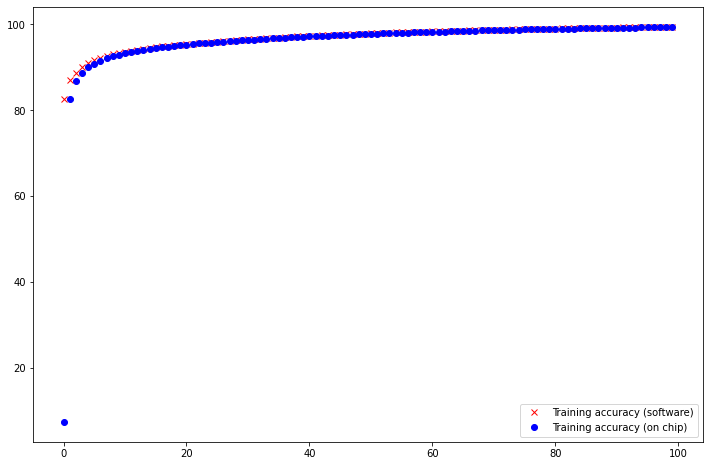

In [62]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, 'rx')
plt.plot(trainAccOnChip, 'bo')
plt.legend(["Training accuracy (software)", "Training accuracy (on chip)"])

In [80]:
import sys
def progressbar(it, prefix="", size=60, out=sys.stdout): # Python3.3+
    count = len(it)
    def show(j):
        x = int(size*j/count)
        print("{}[{}{}] {}/{}".format(prefix, u"█"*x, "."*(size-x), j, count), end='\r', file=out, flush=True)
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    print("\n", flush=True, file=out)

In [81]:
for i in progressbar(range(20), "Training: ", 100):
    time.sleep(0.1) # any code you need

Training: [████████████████████████████████████████████████████████████████████████████████████████████████████] 20/20

